In [21]:
import pandas as pd
import spacy
from fuzzywuzzy import process

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load data
df = pd.read_excel("DA - Task 1..xlsx", sheet_name=0)
taxonomy = pd.read_excel("DA - Task 1..xlsx", sheet_name="Taxonomy")

# Extract taxonomy lists
root_causes = taxonomy['Root Cause'].dropna().unique().tolist()
symptom_conditions = taxonomy['Symptom Condition '].dropna().unique().tolist()
symptom_components = taxonomy['Symptom Component'].dropna().unique().tolist()
fix_conditions = taxonomy['Fix Condition'].dropna().unique().tolist()
fix_components = taxonomy['Fix Component'].dropna().unique().tolist()

# Combine text fields
df['combined_text'] = df[['Complaint', 'Cause', 'Correction']].fillna('').agg(' '.join, axis=1)

# Function to extract keywords using spaCy
def extract_keywords(text):
    doc = nlp(text.lower())
    return [chunk.text for chunk in doc.noun_chunks] + [token.lemma_ for token in doc if token.pos_ in ['VERB', 'ADJ']]

# Fuzzy match top 3 keywords
def fuzzy_top_matches(keywords, category_list, top_n=3):
    matches = []
    for keyword in keywords:
        match, score = process.extractOne(keyword, category_list)
        if score > 80 and match not in matches:
            matches.append(match)
        if len(matches) == top_n:
            break
    return matches + [None] * (top_n - len(matches))  # pad with None if fewer than 3

# Apply hierarchical tagging
for index, row in df.iterrows():
    keywords = extract_keywords(row['combined_text'])

    # root cause
    sc_matches = fuzzy_top_matches(keywords, root_causes)
    df.at[index, 'Root Cause'] = sc_matches[0]

    # Symptom Conditions
    sc_matches = fuzzy_top_matches(keywords, symptom_conditions)
    df.at[index, 'Symptom Condition 1'] = sc_matches[0]
    df.at[index, 'Symptom Condition 2'] = sc_matches[1]
    df.at[index, 'Symptom Condition 3'] = sc_matches[2]

    # Symptom Components
    sp_matches = fuzzy_top_matches(keywords, symptom_components)
    df.at[index, 'Symptom Component 1'] = sp_matches[0]
    df.at[index, 'Symptom Component 2'] = sp_matches[1]
    df.at[index, 'Symptom Component 3'] = sp_matches[2]

    # Fix Conditions
    fc_matches = fuzzy_top_matches(keywords, fix_conditions)
    df.at[index, 'Fix Condition 1'] = fc_matches[0]
    df.at[index, 'Fix Condition 2'] = fc_matches[1]
    df.at[index, 'Fix Condition 3'] = fc_matches[2]

    # Fix Components
    fp_matches = fuzzy_top_matches(keywords, fix_components)
    df.at[index, 'Fix Component 1'] = fp_matches[0]
    df.at[index, 'Fix Component 2'] = fp_matches[1]
    df.at[index, 'Fix Component 3'] = fp_matches[2]

# Save the tagged dataset
df.drop(columns=['combined_text'], inplace=True)
df.to_excel("Tagged_Dataset_Hierarchical.xlsx", index=False)


Step-by-Step EDA Breakdown

In [38]:

df1 = pd.read_excel("Tagged_Dataset_Hierarchical.xlsx")
print(df1.shape)
print(df1.columns)
print(df1.info())
print(df1.isnull().sum())

(20, 19)
Index(['Primary Key', 'Order Date', 'Product Category', 'Complaint', 'Cause',
       'Correction', 'Root Cause', 'Symptom Condition 1',
       'Symptom Component 1', 'Symptom Condition 2', 'Symptom Component 2',
       'Symptom Condition 3', 'Symptom Component 3', 'Fix Condition 1',
       'Fix Component 1', 'Fix Condition 2', 'Fix Component 2',
       'Fix Condition 3', 'Fix Component 3'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Primary Key          20 non-null     object        
 1   Order Date           20 non-null     datetime64[ns]
 2   Product Category     20 non-null     object        
 3   Complaint            20 non-null     object        
 4   Cause                20 non-null     object        
 5   Correction           20 non-null     object        
 6   Root Cause 

Root Cause Distribution

<Axes: title={'center': 'Root Cause Frequency'}, ylabel='Root Cause'>

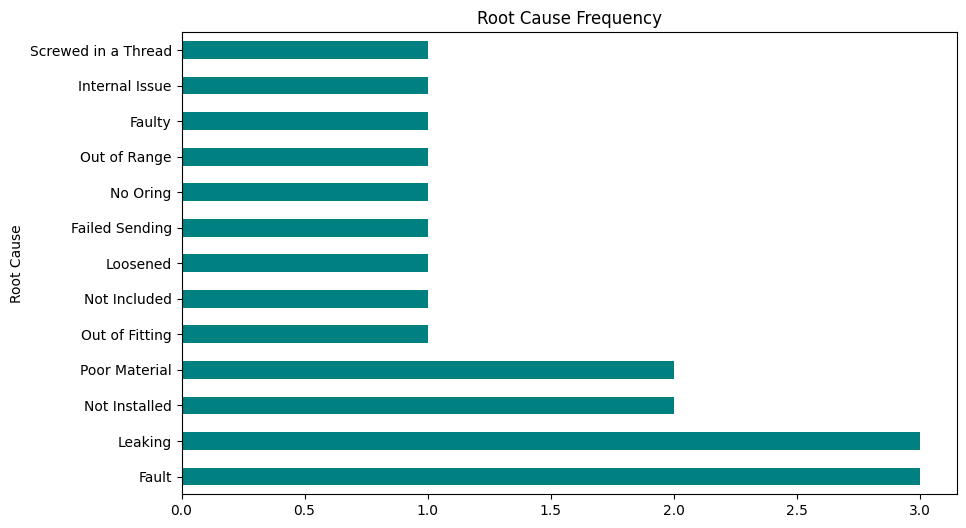

In [39]:
root_counts = df1['Root Cause'].value_counts()
root_counts.plot(kind='barh', figsize=(10,6), title='Root Cause Frequency', color='teal')


Fix Condition vs Component **Matrix**

Text(0.5, 1.0, 'Fix Condition vs Fix Component')

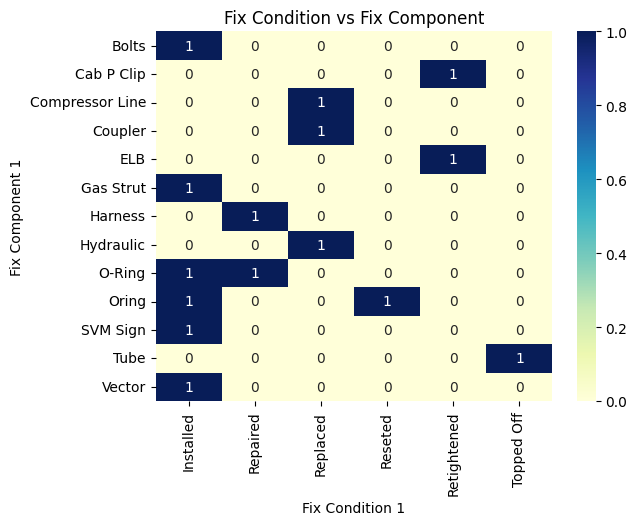

In [41]:
fix_matrix = pd.crosstab(df1['Fix Component 1'], df1['Fix Condition 1'])
sns.heatmap(fix_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Fix Condition vs Fix Component")


Highlights which fixes are applied to which components.

Useful for technician training and SOP optimization.

Complaint Trends Over Time

<Axes: title={'center': 'Complaint Volume Over Time'}, xlabel='Order Date'>

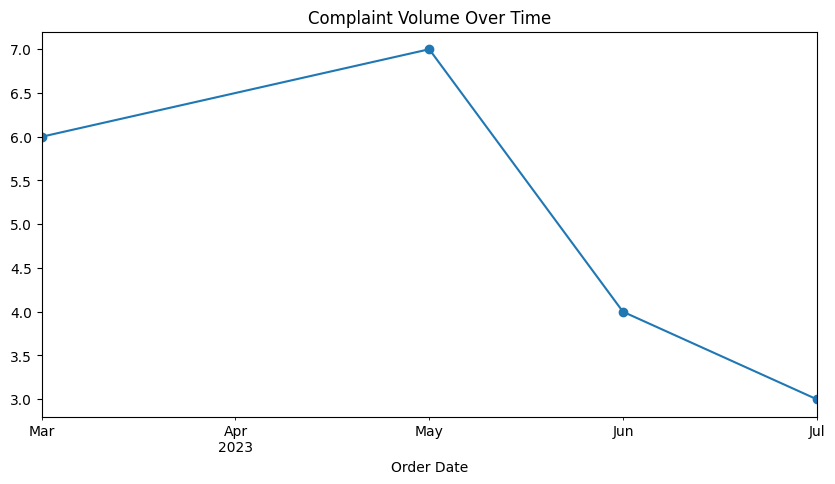

In [42]:
df['Order Date'] = pd.to_datetime(df1['Order Date'])
monthly_trend = df.groupby(df1['Order Date'].dt.to_period('M')).size()
monthly_trend.plot(kind='line', marker='o', title='Complaint Volume Over Time', figsize=(10,5))


Detects seasonal spikes or batch-related issues.

Can be filtered by product category (e.g., SPRAYS vs BALER).

 2. Top Symptom **Components**

/tmp/ipython-input-1777276097.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_components.values, y=top_components.index, palette='viridis')


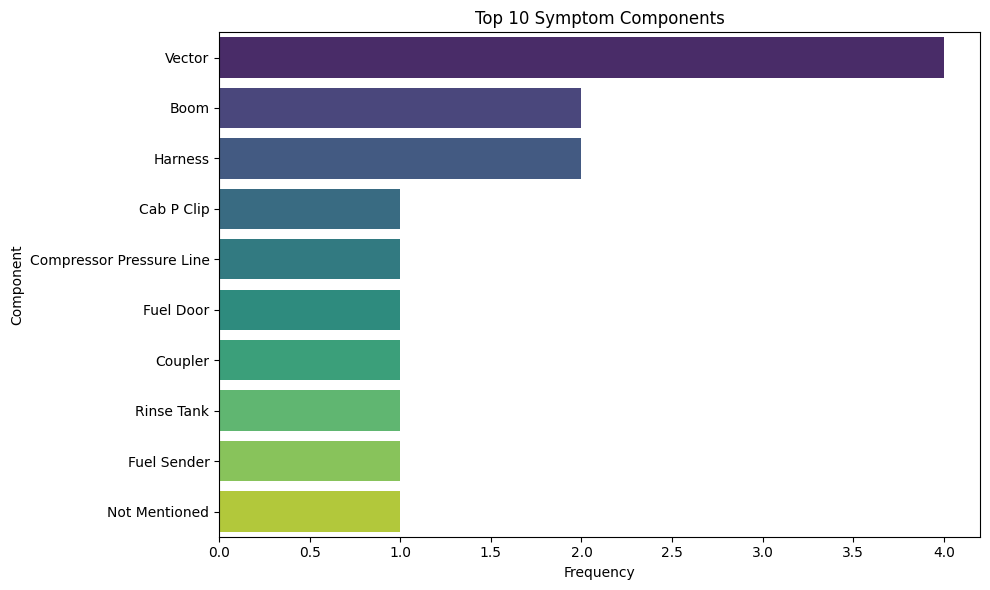

In [43]:


# 2. Top Symptom Components
top_components = df1['Symptom Component 1'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_components.values, y=top_components.index, palette='viridis')
plt.title("Top 10 Symptom Components")
plt.xlabel("Frequency")
plt.ylabel("Component")
plt.tight_layout()
plt.show()
